## Introduction
In this notebook we will create the dataset class used to feed slices and corresponding segmentation masks to the network during training

## Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug to set the random seed
* SegmentationMapsOnImage from imgaug to augment the segmentation map

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np
# import imgaug
# import imgaug.augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from torchvision import tv_tensors
from torchvision.tv_tensors import Mask
from torchvision.transforms import v2



## DataSet Creation
We need to implement the following functionality:
1. Create a list of all 2D slices. To do so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [2]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod   # no need for it to acept self, as it does not access any class atributes
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        # print(files)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        # print(Path(*parts))
        return Path(*parts)

    def augment(self, img, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        # random_seed = torch.randint(0, 1000000, (1,)).item()
        # imgaug.seed(random_seed)
        #####################################################

        # mask = SegmentationMapsOnImage(mask, mask.shape)
        # slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        # mask_aug = mask_aug.get_arr()
        # return slice_aug, mask_aug

        # random_seed = torch.randint(0, 1000000, (1,)).item()
        # torch.manual_seed(random_seed)                             # v2 transforms automatically handles this

        img =torch.tensor([img])
        mm = Mask(torch.tensor([mask]))    # create an instance of Mask. this is necessary for v2 transforms to handle identically both the img and the mask

        aug_img, aug_mask  = self.augment_params(img, mm)

        # aug_img = aug_img.unsqueeze(0)
        # aug_mask = aug_mask.unsqueeze(0)
        
        # aug_img = tv_tensors.Image(aug_img)
        # aug_mask = tv_tensors.Image(aug_mask)

        aug_img = torch.tensor(aug_img)
        aug_mask  = torch.tensor(aug_mask)
                 
        # aug_img = torch.tensor(np.array(aug_img).astype('float32'))
        # aug_mask = torch.tensor(np.array(aug_mask).astype('float32')) 

        return aug_img, aug_mask



    
    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torch
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        # Note that pytorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height and W to Width.
        # As our data is of shape (HxW) we need to manually add the C axis by using expand_dims.
        # The batch dimension is later added by the dataloader

        # # return np.expand_dims(slice, 0), np.expand_dims(mask, 0) 
    
        # # return slice, mask
    
        return slice, mask


        

Now we can test our dataset!
Let us at first define the data augmentation routine responsible for scaling and rotation.

In [3]:
# seq = iaa.Sequential([
#     iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
#                rotate=(-45, 45)),  # Rotate up to 45 degrees
#     iaa.ElasticTransformation()  # Random Elastic Deformations
#                 ])


In [4]:
train_transforms = v2.Compose([
                                    # v2.ToImage(),  # Convert numpy array to tensor
                                    v2.RandomAffine(degrees=(-45, 45), scale=(0.8, 1.2)), # Data Augmentation
                                    v2.ElasticTransform()
])      


In [5]:
# Create the dataset object
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path, train_transforms)
# dataset = CardiacDataset(path, None)

Finally, we can visualize our dataset.
To make sure that the augmentation works properly, we access the same dataset element multiple times and visualize the augmented images and masks.

Please chose an index where the left atrium is visible

In [6]:
slice, mask = dataset[50]
print(slice.shape, mask.shape)
print(mask.sum())

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
tensor(1572)


/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1742908952465/work/torch/csrc/utils/tensor_new.cpp:257.)
  img =torch.tensor([img])
/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aug_img = torch.tensor(aug_img)
/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

In [7]:
dataset[50]

/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aug_img = torch.tensor(aug_img)
/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aug_mask  = torch.tensor(aug_mask)


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8))

/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aug_img = torch.tensor(aug_img)
/var/folders/dm/c_0d36ss7sq2scgssjrhgbrc0000gn/T/ipykernel_63142/2741737172.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aug_mask  = torch.tensor(aug_mask)


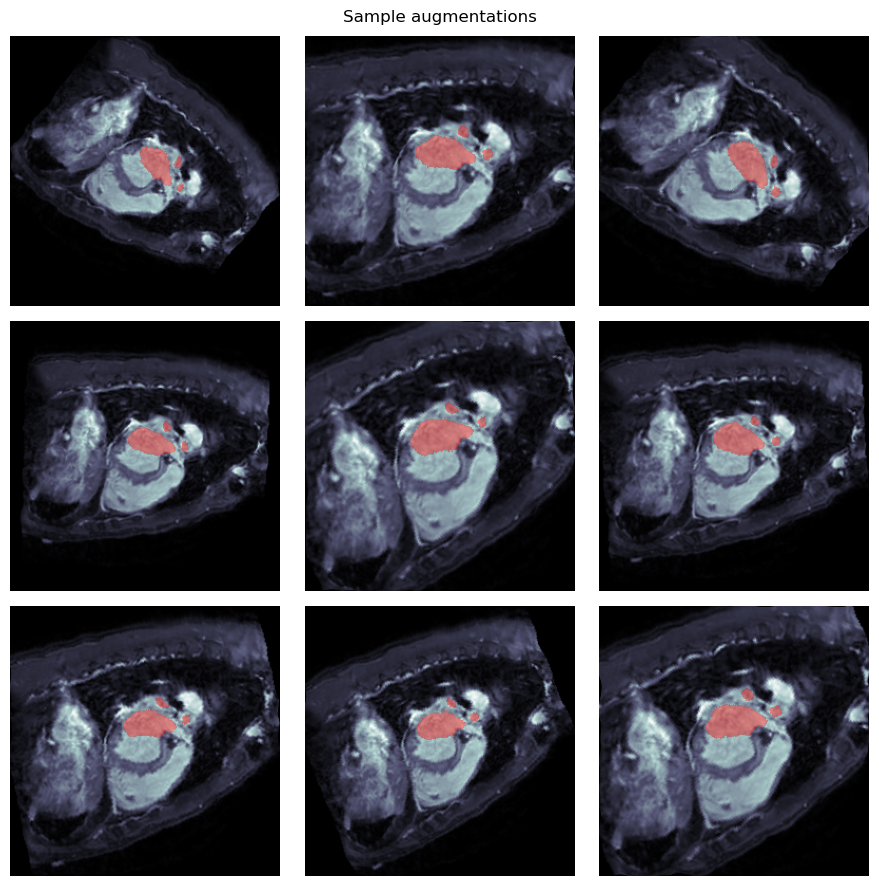

In [8]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[47]
        # slice = slice.squeeze(0)
        # mask = mask.squeeze(0)

        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn", alpha = 0.4)
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


Nice!
With above dataset we can finally create the model and train the AtriumSegmenter